In [1]:
EMBEDDINGS_PATH = './getHereYourResults'
IMAGES_PATH = '/home/sefidrodi/data/img_celeba'
ID_FILE = '/home/sefidrodi/data/identity_CelebA.txt'

In [2]:
import os
import numpy as np
import csv
embeddings = np.load(os.path.join(EMBEDDINGS_PATH, 'embeddings.npy'))
label_string = np.load(os.path.join(EMBEDDINGS_PATH,'label_strings.npy'))
labels = np.load(os.path.join(EMBEDDINGS_PATH, 'labels.npy'))
image_list = np.load(os.path.join(EMBEDDINGS_PATH, 'image_list.npy'))
img_2_ids = dict(list(csv.reader(open(ID_FILE, 'r'), delimiter=' ')))
ids_2_imgs = dict()
for img, identity in img_2_ids.items():
    if identity not in ids_2_imgs:
        ids_2_imgs[identity] = set()
    ids_2_imgs[identity].add(img)
ids_2_idx = dict()
idx_2_id = [None] * len(img_2_ids)
for ind, img in enumerate(image_list):
    id_ = img_2_ids[img.decode('utf-8')]
    idx_2_id[ind] = int(id_)
    if id_ not in ids_2_idx:
        ids_2_idx[id_] = set()
    ids_2_idx[id_].add(ind)        

In [3]:
import numpy as np
from sklearn.neighbors import KDTree
tree = KDTree(embeddings)

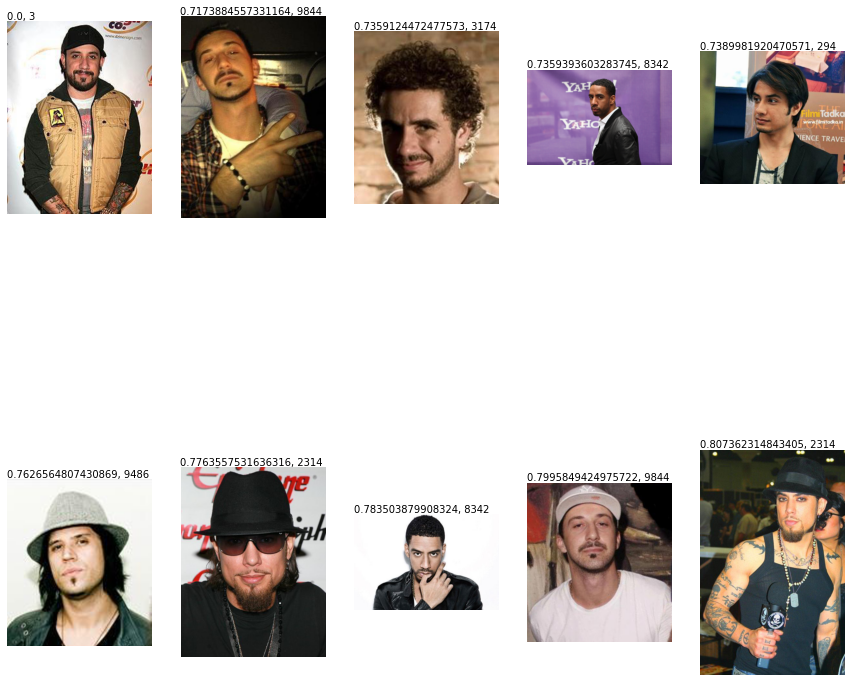

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image

def img_reshape(image_path, width=300, height=300):
    img = Image.open(image_path).convert('RGB')
    wpercent = (width/float(img.size[0]))
    hsize = int((float(img.size[1])*float(wpercent)))
    img = img.resize((width,hsize))
    img = np.asarray(img)
    return img

def nearest_neighbours(identity, embeddings, idx_2_id, image_list, images_path, neighbours=3, exclude_identity=False):
    index = next(iter(ids_2_idx[str(identity)]))
    emb = embeddings[index]
    display_images = [os.path.join(images_path, image_list[index].decode("utf-8"))]
    dist, neighbour_indices = tree.query([emb], k=neighbours)
    for idx in neighbour_indices[0][1:]:
        if (exclude_identity and idx_2_id[idx] != identity) or not exclude_identity:
            display_images.append(os.path.join(images_path, image_list[idx].decode("utf-8")))
    return display_images, dist

def plot_images(images, img_2_ids, cols=5, distances=None):
    rows = int(len(images) / cols)
    img_count = 0
    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(15,15))
    img_arr = []
    for image in images:
        img_arr.append(img_reshape(image))
    for i in range(rows):
        for j in range(cols):        
            if img_count < len(images):
                axes[i, j].imshow(np.asarray(img_arr[img_count]))
                if distances is not None:
                    axes[i, j].text(-1,-5,str(distances[0][img_count])+', '+img_2_ids[os.path.split(images[img_count])[1]])
                axes[i, j].set_axis_off()
                img_count+=1

nn, dist = nearest_neighbours(3, embeddings, idx_2_id, image_list, IMAGES_PATH, neighbours=30, exclude_identity=True)
plot_images(nn, img_2_ids, distances=dist)

In [5]:
single_image_ids_2_idx = {k: list(v)[0] for k,v in ids_2_idx.items()}
single_image_idx = list(single_image_ids_2_idx.values())
single_image_embeddings = embeddings[single_image_idx]
single_imgs = image_list[single_image_idx]

In [101]:
from sklearnex import patch_sklearn
patch_sklearn()
from sklearn.cluster import OPTICS
import numpy as np
clustering = OPTICS(min_samples=2, metric='euclidean', xi=0.25).fit(single_image_embeddings)

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [11]:
cluster = {}
for idx, label  in enumerate(clustering.labels_):
    if label not in cluster:
        cluster[label] = []
    cluster[label].append(idx)

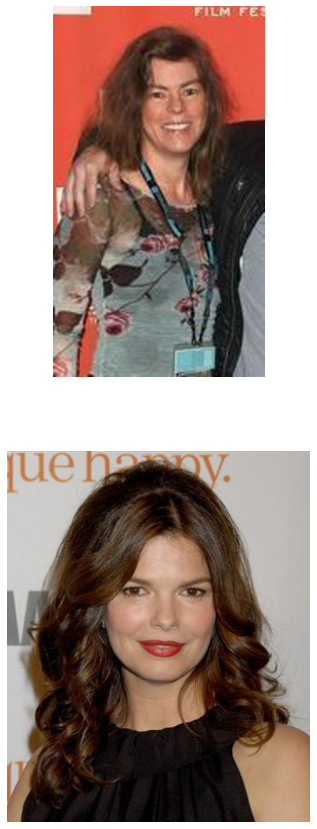

In [103]:
def cluster_images(cluster, image_list, images_path):
    images = []
    for id_ in cluster:
        images.append(os.path.join(images_path, image_list[id_].decode("utf-8")))
    return images

def plot_cluster(images, cols=1):
    rows = int(len(images) / cols)
    img_count = 0
    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(15,15))
    img_arr = []
    for image in images:
        img_arr.append(img_reshape(image))
    if (rows>1 and cols>1):
        for i in range(rows):
            for j in range(cols):
                if img_count < len(images):
                    axes[i, j].imshow(np.asarray(img_arr[img_count]))
                    axes[i, j].set_axis_off()
                    img_count+=1
    else:
        for i in range(rows):
            if img_count < len(images):
                axes[i].imshow(np.asarray(img_arr[img_count]))
                axes[i].set_axis_off()
                img_count+=1
images = cluster_images(cluster[list(cluster.keys())[33]], single_imgs, IMAGES_PATH)
plot_cluster(images)
